In [1]:
import seaborn as sns
import json
import pandas as pd
from numpy import mean, percentile, array
from numpy.random import permutation as perm
from pathlib import Path

In [2]:
base_dir = Path()
data_dir = base_dir / "data"

In [3]:
def read_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for i,line in enumerate(file):
            data.append(json.loads(line))
    return data

reviews = read_jsonl(data_dir / "cmu" / "raw" / "review.txt")
offering = read_jsonl(data_dir / "cmu" / "raw" / "offering.txt")


In [25]:
with open(data_dir / "cmu" / "processed" / "cities.json", "w") as f:
    json.dump(list(cities), f)
    
with open(data_dir / "cmu" / "processed" / "score_threshold_per_city.json", "w") as f:
    json.dump(score_threshold_per_city, f)

with open(data_dir / "cmu" / "processed" / "city_to_hotel_id_map.json", "w") as f:
    json.dump(city_to_hotel_id_map, f)

with open(data_dir / "cmu" / "processed" / "hotel_id_to_name_map.json", "w") as f:
    json.dump(hotel_id_to_name_map, f)

with open(data_dir / "cmu" / "processed" / "hotel_id_to_review_map.json", "w") as f:
    json.dump(hotel_id_to_review_map, f)
    

In [4]:
cities = set([hotel['address']['locality'] for hotel in offering])
city_to_hotel_id_map = {city: [hotel['id'] for hotel in offering 
                               if hotel['address']['locality'] == city] for city in cities}

In [5]:
hotel_id_to_review_map = {}
for review in reviews:
    review_info = {'text': review['text'], 'score': review['ratings']['overall'], 'num_helpful': review['num_helpful_votes']}
    hotel_id_to_review_map.setdefault(review['offering_id'], []).append(review_info)

for hotel_id, review_info in hotel_id_to_review_map.items():
    average_score = mean([rev['score'] for rev in review_info])
    hotel_id_to_review_map[hotel_id] = {'average_score': average_score, 'reviews': review_info}


In [6]:
hotel_id_to_name_map = {hotel["id"]: hotel["name"] for hotel in offering}

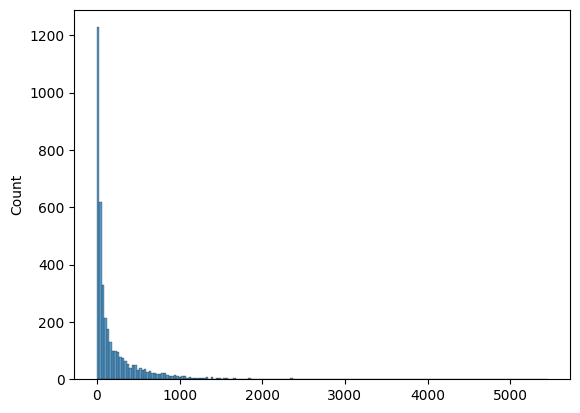

In [7]:
sns.histplot([len(hotel['reviews']) for hotel in hotel_id_to_review_map.values()]);

In [8]:
def calc_score_threshold_per_city(p):
    res = {}
    for city, idxs in city_to_hotel_id_map.items():
        res[city] = percentile([hotel_id_to_review_map.get(idx, {'average_score': 0})['average_score'] for idx in idxs], p)  
    return res

In [9]:
score_threshold_per_city=calc_score_threshold_per_city(80)

In [11]:
reviews_per_hotel_per_city = {}
for city in city_to_hotel_id_map:
    for hotel_id in city_to_hotel_id_map[city]:
        n_reviews = len(hotel_id_to_review_map.get(hotel_id, {'reviews': []})['reviews'])
        reviews_per_hotel_per_city.setdefault(city, []).append(n_reviews)

In [13]:
for city, num_reviews in reviews_per_hotel_per_city.items():
    score_threshold = score_threshold_per_city[city]
    for idx in city_to_hotel_id_map[city]:
        hotel_id_to_review_map.get(idx, {'average_score': 0})['average_score']
    print(f"{city}: {(array(num_reviews) > 70).sum()} hotels with more than 100 reviews")

Boston: 73 hotels with more than 100 reviews
Seattle: 86 hotels with more than 100 reviews
San Jose: 24 hotels with more than 100 reviews
Charlotte: 49 hotels with more than 100 reviews
Chicago: 106 hotels with more than 100 reviews
Washington DC: 106 hotels with more than 100 reviews
Fort Worth: 15 hotels with more than 100 reviews
Jacksonville: 39 hotels with more than 100 reviews
Denver: 70 hotels with more than 100 reviews
Los Angeles: 142 hotels with more than 100 reviews
New York City: 327 hotels with more than 100 reviews
Dallas: 61 hotels with more than 100 reviews
Memphis: 42 hotels with more than 100 reviews
Phoenix: 62 hotels with more than 100 reviews
San Diego: 148 hotels with more than 100 reviews
Austin: 63 hotels with more than 100 reviews
Baltimore: 41 hotels with more than 100 reviews
San Antonio: 89 hotels with more than 100 reviews
Detroit: 17 hotels with more than 100 reviews
Indianapolis: 44 hotels with more than 100 reviews
San Francisco: 177 hotels with more tha

In [ ]:
offering

memory in gradio space

Steps:
* Embed space in site
* Save preprocessed files
* Load from interface
* Return recommendation for boston irrespective of text input
    * Return context for llm as output
    * Set up open ai, return raw output with basic prompt
* Scroll menu for city
* Check box for kid friendly
* At the end - understand free text input
    

In [17]:
hotel_id_to_review_map = {
    hotel_id: {
        "reviews": [
            review for review in hotel_data["reviews"] if review["num_helpful"] > 10
        ]
    }
    for hotel_id, hotel_data in hotel_id_to_review_map.items()
    if len(hotel_id_to_review_map[hotel_id]['reviews']) > 100
    and hotel_id_to_review_map[hotel_id]['average_score'] >= score_threshold_per_city[hotel_id_to_city_map[hotel_id]]
}

In [18]:
hotel_id_to_city_map = {vi:k for k,v in city_to_hotel_id_map.items() for vi in v}

In [23]:
city = "Boston"
score_threshold = score_threshold_per_city[city]
for hotel_id in perm(city_to_hotel_id_map[city]):
    try:
        hotel_reviews = hotel_id_to_review_map[hotel_id]['reviews']
    except KeyError:
        continue
    res = {"hotel_name": hotel_id_to_name_map[hotel_id], 'positive': [], 'negative': []}    
    hotel_reviews = hotel_id_to_review_map[hotel_id]['reviews']
    for review in perm(hotel_reviews):
        if review['num_helpful'] > 10:
            if (review['score'] == 5) & (len(res['positive']) < 3):
                res['positive'].append(review)
            if (review['score'] <= 2) & (len(res['negative']) < 1):
                res['negative'].append(review)
    if (len(res['positive']) >= 3) & (len(res['negative']) >= 1):
        break

print(res)


{'hotel_name': 'Four Seasons Hotel Boston', 'positive': [{'text': "FSHB is one of the best hotels in the country. Its employees are pleasant, professional, and well trained. They always have the guests' best interests in mind. The hotel is beautiful, the rooms spacious, clean, andextremely comfortable. The restaurant, Aujourd'hui, is among the best in the city. The food is exquisite. Room service and brunch are also wonderful. This is the best Boston has to offer!", 'score': 5.0, 'num_helpful': 11}, {'text': 'I had the opportunity to stay at the 4 seasons for the Boston Marathon. It was my first time to Boston (where I had wanted to go since my early twenties, (48 now)!. I have to say the 4 seasons made this the best experience of my life. From the pickup at the airport to the drop off I was simply amazed! Everyone was so nice, Daniel the concierge helped me get a tour of the city prior to other relatives arriving and referred me to 5th Avenue Limo Service. Use them please, they are gr